In [0]:
import numpy as np
import re
import itertools
from collections import Counter
import pandas as pd
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D ,LSTM,GRU,Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import math, codecs

Using TensorFlow backend.


In [0]:
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M.vec.zip

--2019-03-04 16:49:12--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M.vec.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.1
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  70.9MB/s    in 21s     

2019-03-04 16:49:34 (69.1 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [0]:
!unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

886it [00:00, 8857.33it/s]

loading word embeddings...


1999996it [03:54, 8521.43it/s]

found 1999996 word vectors


In [0]:
def load_data_and_labels():
    """
    Loads  data from internet and generates labels.
    Returns  sentences and labels.
    """
    # Load data from internet
    if('blogs.zip' not in os.listdir()):
        !curl 'http://u.cs.biu.ac.il/~koppel/blogs/blogs.zip' -H 'Connection: keep-alive' -H 'Upgrade-Insecure-Requests: 1' -H 'User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8' -H 'Referer: http://u.cs.biu.ac.il/~koppel/BlogCorpus.htm' -H 'Accept-Encoding: gzip, deflate' -H 'Accept-Language: en-US,en;q=0.9' --compressed --output blogs.zip
        with zipfile.ZipFile('blogs.zip', 'r') as zip_ref:
            zip_ref.extractall('./')
    bloggers = os.listdir('blogs/')
    idx = []
    gender = []
    age = []
    industry = []
    astrologic = []
    dates = []
    posts = []
    path = 'blogs/'
    for blogger in bloggers:

        try:

            f = open(path+blogger,'r',encoding="utf-8")
            xml = f.read()

        except UnicodeDecodeError:

            f = open(path+blogger,'r',encoding="latin-1")
            xml = f.read()

        posts += re.findall('<post.*?>(.*?)</post>',xml,flags=re.DOTALL)

        dates += re.findall('<date.*?>(.*?)</date>',xml,flags=re.DOTALL)

        nb_posts = len(re.findall('<post.*?>(.*?)</post>',xml,flags=re.DOTALL))

        tmp = blogger.split(".")

        idx        += [tmp[0]]*nb_posts
        gender     += [tmp[1]]*nb_posts
        age        += [tmp[2]]*nb_posts
        industry   += [tmp[3]]*nb_posts
        astrologic += [tmp[4]]*nb_posts
    dico = {'id':idx,
        'gender':gender,
        'age':age,
        'industry':industry,
        'astrologic':astrologic,
        'post':posts,
        'date':dates}

    data = pd.DataFrame.from_dict(dico)
    corpus = data#[0:100000]
    male_exemples = corpus[corpus['gender']=='male']['post']
    female_exemples = corpus[corpus['gender']=='female']['post']
    x_text = pd.concat([male_exemples , female_exemples])
    male_labels = [[0] for _ in male_exemples]
    female_labels = [[1] for _ in female_exemples]
    y = np.concatenate([male_labels, female_labels], 0)
    return [x_text, y]


In [0]:
sns.set_style("whitegrid")
np.random.seed(0)

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
MAX_NB_WORDS = 100000
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [0]:
from subprocess import check_output
print(check_output(["ls", "."]).decode("utf8"))

crawl-300d-2M.vec
crawl-300d-2M.vec.zip
sample_data



In [0]:
sentences,labels = load_data_and_labels()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  298M  100  298M    0     0   301k      0  0:16:55  0:16:55 --:--:--  305k


In [0]:
print("number of examples: ", sentences.shape[0])

number of examples:  681288


In [0]:
word_len_dist = pd.Series([len(words.split(" ")) for words in sentences])
max_seq_len = np.round(word_len_dist.mean() + word_len_dist.std()).astype(int)
print("The max length choisi: ", max_seq_len)

The max length choisi:  671


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


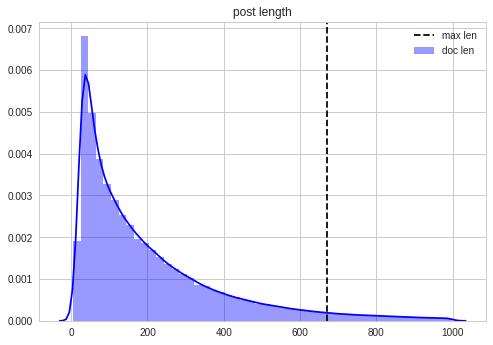

In [0]:
sns.distplot(word_len_dist[word_len_dist < 1000], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('post length'); plt.legend()
plt.show()

In [0]:
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            yield wnl.lemmatize(word, pos='r')
        else:
            yield word

In [0]:
# drop stops word
tokenizer = RegexpTokenizer(r'\w+')
raw_docs_train = sentences.tolist()
print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
  tokens = tokenizer.tokenize(doc)
  filtered = [word for word in tokens if word not in stop_words]
  processed_docs_train.append(" ".join(filtered))
#end for
# fit a keras Tokenizer
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train )  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

  0%|          | 1502/681288 [00:00<00:45, 15009.03it/s]

pre-processing train data...


100%|██████████| 681288/681288 [00:53<00:00, 12827.61it/s]


tokenizing input data...
dictionary size:  720125


In [0]:
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(word_seq_train, labels, test_size=0.2, random_state=42)

In [0]:
batch_size = 256 
num_epochs = 5

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-5
nb_words = min(MAX_NB_WORDS, len(word_index))

In [0]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
embedding_matrix = np.zeros((nb_words+1, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 11088


In [0]:
print("sample words not found: ", np.random.choice(words_not_found, 10))


sample words not found:  ['àï' 'àò' 'å³¹' 'ronathon2000' 'nietzche' 'kikikikikiki' 'alwahab' 'n0e'
 'gibo' 'agghh']


# FastText Embeddings




In [0]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words+1, embed_dim,
           input_length=max_seq_len , weights=[embedding_matrix]#, trainable=False
           ))
model.add(Conv1D(128,kernel_size=7,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128,kernel_size=7,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.35))
model.add(Conv1D(128,kernel_size=7,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
#model.add(LSTM(100,return_sequences=True))
model.add(Bidirectional(GRU(100, return_sequences = True)))
model.add(Dropout(0.45))
model.add(Bidirectional(GRU(100, return_sequences = False)))
model.add(Dropout(0.45))
#model.add(Flatten())
model.add(Dense(60,activation='relu', kernel_regularizer=regularizers.l2(0.03) ))
model.add(Dropout(0.45))
model.add(Dense(1,activation='sigmoid', kernel_regularizer=regularizers.l2(0.02) ))  
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

training CNN ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 671, 300)          30000300  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 671, 128)          268928    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 335, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 335, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 335, 128)          114816    
_________________________________________________________________
max_

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [0]:
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list,validation_split=0.1, shuffle=True)

Train on 490527 samples, validate on 54503 samples
Epoch 1/5
490527/490527 [==============================] - 3329s 7ms/step - loss: 0.7521 - acc: 0.6731 - val_loss: 0.6060 - val_acc: 0.6985
Epoch 2/5
490527/490527 [==============================] - 3303s 7ms/step - loss: 0.5823 - acc: 0.7253 - val_loss: 0.5892 - val_acc: 0.7137
Epoch 3/5
  3072/490527 [..............................] - ETA: 53:34 - loss: 0.5374 - acc: 0.7630

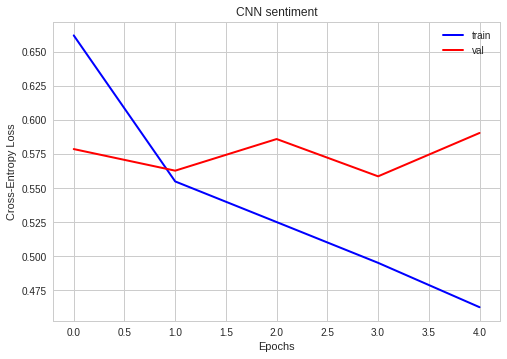

In [0]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

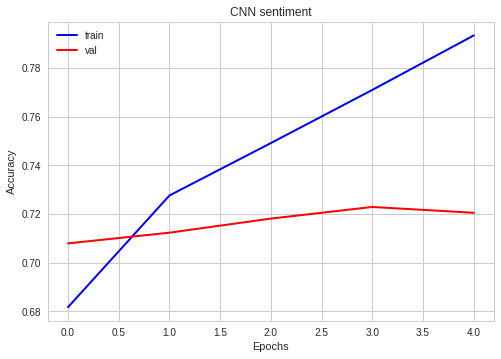

In [0]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [0]:
results = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], results[1]*100))

136258/136258 [==============================] - 1008s 7ms/step
acc: 72.19%


In [0]:
y_pred = model.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(np.squeeze(np.round(y_pred)),np.squeeze(y_test))

0.7205154926683204

# CNN -LSTM


In [0]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words+1, embed_dim,
           input_length=max_seq_len #, weights=[embedding_matrix], trainable=False
           ))
model.add(Conv1D(128,kernel_size=7,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(128,kernel_size=7,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.35))
model.add(Conv1D(128,kernel_size=7,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(1,activation='sigmoid'))  
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 671, 300)          30000300  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 671, 64)           134464    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 335, 64)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 335, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 335, 128)          57472     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 167, 128)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 167, 128)          0   

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [0]:
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list,validation_split=0.1, shuffle=True)

Train on 490527 samples, validate on 54503 samples
Epoch 1/5
490527/490527 [==============================] - 660s 1ms/step - loss: 0.5904 - acc: 0.6800 - val_loss: 0.6120 - val_acc: 0.6959
Epoch 2/5
490527/490527 [==============================] - 657s 1ms/step - loss: 0.5319 - acc: 0.7297 - val_loss: 0.5537 - val_acc: 0.7099
Epoch 3/5
490527/490527 [==============================] - 660s 1ms/step - loss: 0.4963 - acc: 0.7560 - val_loss: 0.5523 - val_acc: 0.7146
Epoch 4/5
490527/490527 [==============================] - 660s 1ms/step - loss: 0.4562 - acc: 0.7831 - val_loss: 0.5591 - val_acc: 0.7110
Epoch 5/5
490527/490527 [==============================] - 663s 1ms/step - loss: 0.4148 - acc: 0.8089 - val_loss: 0.5530 - val_acc: 0.7096


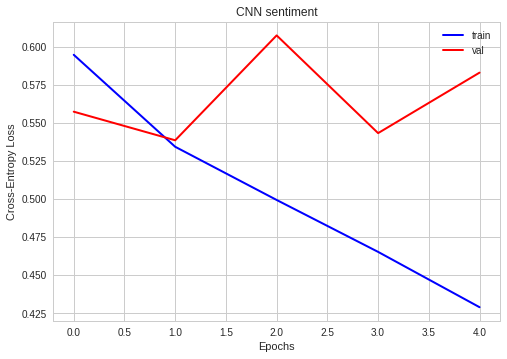

In [0]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

In [0]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [0]:
results = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], results[1]*100))

136258/136258 [==============================] - 289s 2ms/step
acc: 70.92%


In [0]:
y_pred = model.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(np.squeeze(np.round(y_pred)),np.squeeze(y_test))

0.7092134039836193